## Setup

In [ ]:
!pip install datasets
from datasets import Dataset, DatasetDict

import json
import random
import re, os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import transformers
import unicodedata
import numpy as np
from tqdm import notebook as tqdm
from sklearn.model_selection import train_test_split

np.random.seed(42)
random.seed(42)

try:
    assert torch.cuda.is_available()
    device = torch.device("cuda")
except:
    device = torch.device("cpu")
print("Using device:", device)

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

folder = f"/content/drive/MyDrive/DH"

stylized_to_standard = {'ᴇ': 'E','ꜱ': 'S','ᴠ': 'V','ᴅ': 'D','ʀ': 'R','ᴍ': 'M','ɪ': 'I','ᴛ':
                        'T','ʏ': 'Y','ʟ': 'L','ᴘ': 'P','ᴀ': 'A','ɴ': 'N','ꞵ': 'B','ʙ': 'B',
                        'ꞽ': 'Y','ʜ': 'H','Æ': 'AE','ꜰ': 'F','æ': 'ae','ᴏ': 'O','ᴡ': 'W','ᴄ':
                        'C','ᴋ': 'K','ɢ': 'G','ᴢ': 'Z','é': 'e','ô': 'o','ë': 'e','ó': 'o',
                        'á': 'a','œ': 'oe','ȯ': 'o','³': '3','Ꜳ': 'AE','Ꜵ': 'AO','Ꜷ': 'AU'}

def normalize_stylized(text):
    return ''.join(stylized_to_standard.get(char, char) for char in text)

def fix_name(v_id, v2_id):
  if "1 Kings" in v_id and "1 Kings" in v2_id: v_id = "3 Kings" + v_id.split("1 Kings")[-1]
  elif "2 Kings" in v_id and "2 Kings" in v2_id: v_id = "4 Kings" + v_id.split("2 Kings")[-1]
  elif "1 Samuel" in v_id and "1 Samuel" in v2_id: v_id = "1 Kings" + v_id.split("1 Samuel")[-1]
  elif "2 Samuel" in v_id and "2 Samuel" in v2_id: v_id = "2 Kings" + v_id.split("2 Samuel")[-1]
  elif re.search(r"^\d+ Chronicles",v_id): v_id = re.sub(r"Chronicles","Paralipomenon",v_id)
  return v_id

# Load Bibles
bible = {}

to_remove = {}
items = pd.read_csv(f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/overly_vague.csv").to_dict(orient='records')
for entry in items:
  if " - " not in entry['verse_id']: continue
  to_remove[entry['verse_id']] = None

b_versions = ['AKJV','ODRV','Geneva', 'Douay-Rheims', 'Tyndale', 'Wycliffe','Vulgate']
for bname in b_versions:
    data = pd.read_csv(f"{folder}/Early-Modern-Sermons/assets/Bibles/{bname}.csv",header=None)
    data = data.to_dict(orient="records")
    for entry in tqdm.tqdm(data):
        key = entry[0]
        v_id = key.split(" (")[0]
        text = entry[6]
        if re.search("Douay-Rheims",key):
            if re.sub("Douay-Rheims","ODRV",key) in bible: continue
        if len(text.split(" ")) < 200:
            bible[key] = normalize_stylized(f"{v_id} {text}")

        parts = re.split(r'(?<=[\.\?]) (?=[A-Z])|(?<=[\!\:\;])', text)
        parts = [re.sub(r'\s+', ' ', p).strip() for p in parts if len(p.strip(" ")) > 0]
        if (len(parts[0].split(" ")) <= 5 or len(parts[-1].split(" ")) <= 5 or re.search(r"\&\w+\;",parts[0])):
            for pidx, p in enumerate(parts): continue
        elif len(parts) > 1:
            for pidx, p in enumerate(parts):
              p_id = f"{key} - {pidx}"
              if p_id in to_remove: continue
              if len(p) == 0: continue
              if re.search(r"\&\w+\;",p) or len(p.split(" ")) <= 5: continue
              bible[p_id] = normalize_stylized(f"Part {pidx+1} of {v_id}: {p}")

bible['NonQP 0.0'] = "No Biblical quotation or paraphrase found"

bible_verses = list(bible.values())
bible_ids = list(bible.keys())
verse_to_id = {v:k for k,v in bible.items()}
bible_parts = {}
for key, text in bible.items():
  v_id = key.split(" - ")[0]
  if v_id not in bible_parts:
    bible_parts[v_id] = [v_id]
  if " - " not in key: continue
  bible_parts[v_id].append(key)

def get_parts(pos_id):
  parts = []
  if len(bible_parts[pos_id]) > 0:
      for part_id in bible_parts[pos_id]:
        parts.append(part_id)
  return parts

with open(f"{folder}/Early-Modern-Sermons/assets/Bibles/ESV.json",'r') as file:
  ESV = json.load(file)

v_id_to_idx = {v_id:idx for idx, v_id in enumerate(bible_ids)}

len(bible_verses), len(bible_parts)

Mounted at /content/drive


  0%|          | 0/36702 [00:00<?, ?it/s]

  0%|          | 0/14737 [00:00<?, ?it/s]

  0%|          | 0/31090 [00:00<?, ?it/s]

  0%|          | 0/35811 [00:00<?, ?it/s]

  0%|          | 0/7954 [00:00<?, ?it/s]

  0%|          | 0/9622 [00:00<?, ?it/s]

  0%|          | 0/35809 [00:00<?, ?it/s]

(276171, 157011)

In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.util import semantic_search, pytorch_cos_sim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## Load Models

In [ ]:
# model_checkpoint = "emanjavacas/MacBERTh"
# model_name = "MacBERTh"

model_checkpoint = f"{folder}/models/EEPS_emanjavacas-MacBERTh_2025-05-05/checkpoint-1560"
model_name = "EEPS_emanjavacas-MacBERTh_2025-05-05_checkpoint-1560"

# model_checkpoint = f"{folder}/models/EEPS_emanjavacas-MacBERTh_8negs/checkpoint-5000"
# model_name = f"EEPS_emanjavacas-MacBERTh_8negs_checkpoint-5000"

if model_name == 'MacBERTh':
  word_embedding_model = models.Transformer(model_checkpoint, max_seq_length=128)
  pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), "mean")
  bi_encoder = SentenceTransformer(modules=[word_embedding_model, pooling_model])
else:
  bi_encoder = SentenceTransformer(model_checkpoint)

bible_verses_no_prepend = [re.sub(r"^[\d\w\s]+\d+\.\d+\ |^Part \d+ of [\d\w\s]+\d+\.\d+\: ",'',v) for v in bible_verses]
bible_verses[24], bible_verses_no_prepend[24]

# bible_vectors = bi_encoder.encode(bible_verses, batch_size=1024, convert_to_tensor=True, show_progress_bar=True)
# torch.save(bible_vectors, f'{folder}/EEPS/Bibles_{model_name}.pt')
bible_vectors = torch.load(f'{folder}/EEPS/Bibles_{model_name}.pt',map_location=device)

# bible_vectors_no_prepend = bi_encoder.encode(bible_verses_no_prepend, batch_size=1024, convert_to_tensor=True, show_progress_bar=True)
# torch.save(bible_vectors_no_prepend,f"{folder}/EEPS/Bible_no_prepend_{model_name}.pt")
bible_vectors_no_prepend = torch.load(f"{folder}/EEPS/Bible_no_prepend_{model_name}.pt", map_location=device)

len(bible_vectors), len(bible_vectors_no_prepend)

(276171, 276171)

# Parallel Verses, Cross References, Proper Nouns, and Citations


In [ ]:
def get_parallel_data():
    p_data = {}
    # reading training and development data
    with open(f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/confident_labeled.json",'r') as file:
      labeled_dict = json.load(file)
    for ESV_id, pv_list in labeled_dict.items():
      if ESV_id not in ESV: continue
      pv_list = list(set(pv_list))
      p_data[ESV_id] = {'qid': ESV_id,
                        'query': ESV[ESV_id],
                        'pos':{k:None for k in pv_list}, # verse ids with version,
                        'neg': {}
                        }

    parallel = pd.read_csv(f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/parallel_predictions_SAMPLE - FINAL.csv").to_dict(orient='records')
    parallel.extend(pd.read_csv(f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/parallel_predictions_SAMPLE - NEGATIVES.csv").to_dict(orient='records'))

    for item in parallel:
      text = item['text']
      v_id = re.findall(r"^[\w\s]+\d+.\d+",text)[0]
      if v_id in p_data: continue
      if v_id not in p_data:
        p_data[v_id] = {'qid': v_id,
                        'query': ESV[v_id],
                        'pos':{}, # verse ids with version,
                        'neg': {}
                        }
      entry = p_data[v_id]

      v2_id = re.findall(r"^[\w\s]+\d+.\d+",item['verse_text'])[0]
      if re.search(r"Psalms 9\.",v2_id) and item['version'] == 'Douay-Rheims':
          item['version'] = 'ODRV'
      v2_id = v2_id + f" ({item['version']})"
      if item['version'] in ['Vulgate','Douay-Rheims','ODRV']:
        v2_id = fix_name(v2_id, v_id)

        if v2_id == "Psalms 77.59 (ODRV)": v2_id = "Psalms 77.59 (Douay-Rheims)"
      verse_text = bible_verses_no_prepend[v_id_to_idx[v2_id]]

      if item['prediction'] is True and item['label'] is not False:
        entry['pos'][v2_id] = None
      elif item['label'] is True:
        entry['pos'][v2_id] = None
      else:
        entry['neg'][v2_id] = None

    # reading training and development data
    parallel = pd.read_csv(f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/parallel_verses_CONFIDENT.csv")
    parallel['toCheck'] = False
    parallel = parallel.to_dict(orient='records')
    parallel.extend(pd.read_csv(f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/parallel_verses_CONFIDENT - HNDPR.csv").to_dict(orient='records'))
    parallel.extend(pd.read_csv(f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/parallel_verses_CONFIDENT - DSV3.csv").to_dict(orient='records'))

    for item in parallel:
      v_id = item['ESV']
      text = ESV[v_id] # without verse_id prepended

      if v_id not in p_data:
        p_data[v_id] = {'qid': v_id,
                        'query': text,
                        'pos':{}, # high similarity and equivalent numberings
                        'neg':{}
                        }
      entry = p_data[v_id]
      v2_id = item['Parallel'] + f" ({item['version']})"
      # if "1 Samuel" in v_id and "1 Kings" in v2_id:
      #     print(item)
      # if item['version'] in ['Vulgate','Douay-Rheims','ODRV']:
      #     v2_id = fix_name(v2_id, v_id)

      verse_text = bible_verses_no_prepend[v_id_to_idx[v2_id]]
      if item['toCheck'] is False:
        entry['pos'][v2_id] = None
      elif item['prediction'] is True and item['correction'] is not False:
        entry['pos'][v2_id] = None
      else:
        entry['neg'][v2_id] = None

    training_set = {}
    for key, entry in p_data.items():
      entry['pos'] = list(set(entry['pos']))
      if len(entry['pos']) == 0: continue
      training_set[key] = entry
    return training_set

parallel = get_parallel_data()
len(parallel) # ESV_id to positives

31077

In [ ]:
parallel['2 Samuel 1.1']

{'qid': '2 Samuel 1.1',
 'query': 'After the death of Saul, when David had returned from striking down the Amalekites, David remained two days in Ziklag.',
 'pos': ['2 Samuel 1.1 (AKJV)', '2 Samuel 1.1 (Geneva)'],
 'neg': {}}

In [ ]:
bible['1 Kings ']

In [ ]:
with open(f"{folder}/EEPS/cross_references.json",'r') as file:
  CR = json.load(file)
len(CR)

29364

In [ ]:
not_negatives = {}
def add_no_neg(id1,id2):
  if id1 not in not_negatives:
    not_negatives[id1] = {}
  if id2 not in not_negatives:
    not_negatives[id2] = {}
  not_negatives[id1][id2] = None
  not_negatives[id2][id1] = None

In [ ]:
# choose cross references with high similarity (>=0.8)
pv_scores = {}
for ESV_id, item in tqdm.tqdm(sorted(parallel.items())):
  for q_id in item['pos']:
    for p_id in item['pos']:
      add_no_neg(q_id,p_id)
      if q_id == p_id: continue
      if (p_id, q_id) in pv_scores: continue
      key = (q_id,p_id)
      pv_scores[key] = None
len(pv_scores)

  0%|          | 0/31077 [00:00<?, ?it/s]

231380

In [ ]:
check_cr = {}
CR_actual = {}
for ESV_id, item in tqdm.tqdm(parallel.items()):
  if ESV_id not in CR: continue
  for q_id in item['pos']:
    q_ver = q_id.split(" (")[-1].strip(")")
    for cr in CR[ESV_id]:
      if cr in parallel:
        for cr_id in parallel[cr]['pos']:
          key = (q_id,cr_id)
          add_no_neg(q_id,cr_id)

          # must be from the same version
          cr_ver = cr_id.split(" (")[-1].strip(")")
          if q_ver != cr_ver: continue

          if q_id not in CR_actual:
            CR_actual[q_id] = {}
          CR_actual[q_id][cr_id] = None

          if (cr_id, q_id) in check_cr: continue
          if key not in check_cr: check_cr[key] = []
          check_cr[key].append(ESV_id)

len(check_cr), len(CR_actual)

  0%|          | 0/31077 [00:00<?, ?it/s]

(1864490, 117083)

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def make_batches(data,batch_size=10000):
  data = [k for k in data]
  batches = []
  for start_index in range(0, len(data), batch_size):
    batch = data[start_index:start_index + batch_size]
    batches.append(batch)
  print(len(batches), 'batches')
  return batches

def get_sim_scores(data):
  vectors_1 = torch.stack([bible_vectors_no_prepend[v_id_to_idx[x]] for x,y in data])
  vectors_2 = torch.stack([bible_vectors_no_prepend[v_id_to_idx[y]] for x,y in data])
  vectors_1 = F.normalize(vectors_1, p=2, dim=1)
  vectors_2 = F.normalize(vectors_2, p=2, dim=1)
  vectors_1 = vectors_1.unsqueeze(1)
  vectors_2 = vectors_2.unsqueeze(2)
  sim_scores = torch.bmm(vectors_1, vectors_2)
  sim_scores = sim_scores.squeeze()
  sim_scores = sim_scores.tolist()
  return sim_scores

def plot_normal(data, xlabel='Cosine Similarity'):
  mean = np.mean(data)
  std = np.std(data)

  x = np.linspace(min(data), max(data), 100)
  pdf = norm.pdf(x, mean, std)
  plt.plot(x, pdf)
  plt.title(f'{model_name}\nMean={mean:.2f}, Std={std:.2f}')
  plt.xlabel(xlabel)
  plt.ylabel('Probability Density')
  plt.show()

24 batches


  0%|          | 0/24 [00:00<?, ?it/s]

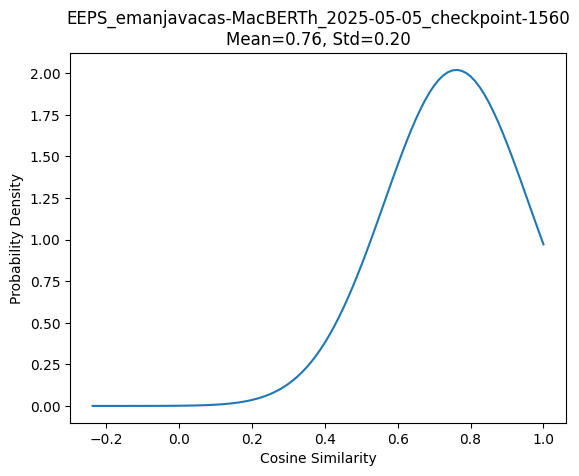

In [ ]:
pv_batches = make_batches(pv_scores)
for batch in tqdm.tqdm(pv_batches):
  sim_scores = get_sim_scores(batch)
  for idx, score in enumerate(sim_scores):
    q_id, cr_id = batch[idx]
    pv_scores[(q_id, cr_id)] = score
plot_normal(list(pv_scores.values()))

187 batches


  0%|          | 0/187 [00:00<?, ?it/s]

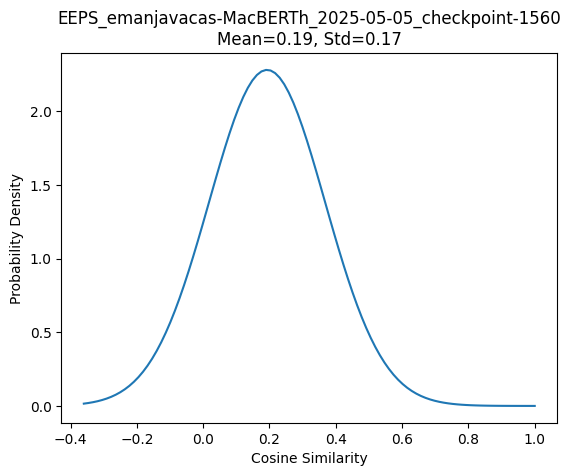

In [ ]:
check_cr_batches = make_batches(check_cr)
CR_mapping = {}

for batch in tqdm.tqdm(check_cr_batches):
  sim_scores = get_sim_scores(batch)
  for idx, score in enumerate(sim_scores):
    q_id, cr_id = batch[idx]
    # print(score)
    # print(q_id,bible_verses_no_prepend[v_id_to_idx[q_id]])
    # print(cr_id, bible_verses_no_prepend[v_id_to_idx[cr_id]])
    # print()
    CR_mapping[(q_id, cr_id)] = score
plot_normal(list(CR_mapping.values()))

In [ ]:
with open(f"{folder}/EEPS/CR_Actual.json",'w+') as file:
  json.dump(CR_actual, file)

## Split & Sample

In [ ]:
bible_parts = {}
for key, text in bible.items():
  v_id = key.split(" - ")[0]
  if " - " not in key: continue
  if v_id not in bible_parts:
    bible_parts[v_id] = [v_id]
  bible_parts[v_id].append(key)
len(bible_parts)

54499

In [ ]:
training_data = {}
for q_id, p_id in pv_scores.keys():
  if q_id == p_id: continue
  if q_id not in bible_parts: continue
  for part_id in bible_parts[q_id]:
    if part_id not in training_data:
      training_data[part_id] = {'qid':part_id,
                           'pos':{},
                           'neg':{}}
    training_data[part_id]['pos'][p_id] = None

  if p_id not in bible_parts: continue
  for part_id in bible_parts[p_id]:
    if part_id not in training_data:
      training_data[part_id] = {'qid':part_id,
                           'pos':{},
                           'neg':{}}
    training_data[part_id]['pos'][q_id] = None

for key, score in CR_mapping.items():
  q_id, p_id = key

  if q_id == p_id: continue
  if p_id not in CR_actual[q_id]: continue
  if q_id not in bible_parts: continue
  for part_id in bible_parts[q_id]:
    if part_id not in training_data:
      training_data[part_id] = {'qid':part_id,
                            'pos':{},
                            'neg':{}}
    if score >= 0.4:
      training_data[part_id]['pos'][p_id] = None
    elif score <= 0.2:
      training_data[part_id]['neg'][p_id] = None

  if p_id not in CR_actual: continue
  if q_id not in CR_actual[p_id]: continue
  if p_id not in bible_parts: continue
  for part_id in bible_parts[p_id]:
    if part_id not in training_data:
      training_data[part_id] = {'qid':p_id,
                            'pos':{},
                            'neg':{}}
    if score >= 0.4:
      training_data[part_id]['pos'][q_id] = None
    elif score <= 0.2:
      training_data[part_id]['neg'][q_id] = None

print(len(training_data))

140197


In [ ]:
Catholic = ['Douay-Rheims','ODRV','Wycliffe','Vulgate']
Protestant = ['Geneva','AKJV','Tyndale']

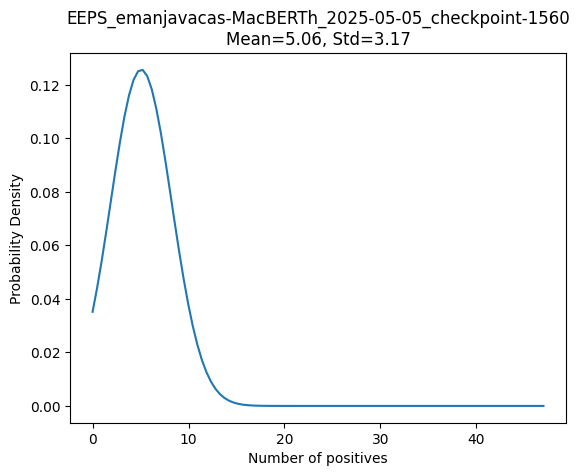

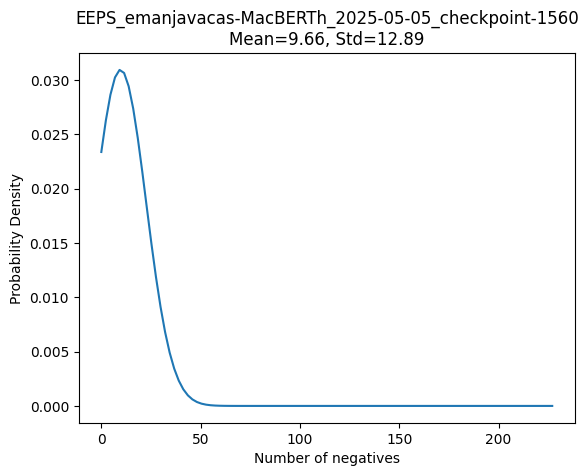

(None, None)

In [ ]:
model_name = "EEPS_emanjavacas-MacBERTh_2025-05-05_checkpoint-1560"
plot_normal([len(vlist['pos']) for vlist in training_data.values()],'Number of positives'),plot_normal([len(vlist['neg']) for vlist in training_data.values()],'Number of negatives')

In [ ]:
import random
random.seed(42)

NUM_NEGATIVES = 2
final_data = {}
for key, item in training_data.items():
  if len(item['neg']) <= NUM_NEGATIVES: continue
  if len(item['pos']) == 0: continue
  final_data[key] = item
print(len(final_data), len(final_data)*NUM_NEGATIVES)

98446 196892


In [ ]:
dev_len = int(len(final_data)*0.01)
dev_keys = {k.split(" - ")[0]:None for k in random.sample(list(final_data.keys()), dev_len)}
dev_data = {}
train_data = {}
for key, item in final_data.items():
  if key.split(" - ")[0] in dev_keys:
    dev_data[key] = item
    continue
  skip = False
  for v_id in item['pos']:
    if v_id.split(" - ")[0] in dev_keys: skip = True
  for v_id in item['neg']:
    if v_id.split(" - ")[0] in dev_keys: skip = True
  if skip: continue
  train_data[key] = item
for item in final_data.values():
  item['pos'] = list(item['pos'].keys())
  item['neg'] = list(item['neg'].keys())
print('Train IDs', len(train_data), 'Dev IDs', len(dev_data))
print('Number of train triplets per epoch (rotate through positives; one pos per query per epoch): ', len(train_data)*NUM_NEGATIVES)
print('Number of dev triplets with one pos per query: ', len(dev_data)*NUM_NEGATIVES)

Train IDs 76163 Dev IDs 3168
Number of train triplets per epoch (rotate through positives; one pos per query per epoch):  152326
Number of dev triplets with one pos per query:  6336


In [ ]:
list(dev_data.items())[4]

('1 Chronicles 12.1 (Geneva) - 0',
 {'qid': '1 Chronicles 12.1 (Geneva) - 0',
  'pos': ['1 Chronicles 12.1 (AKJV)', '2 Samuel 1.1 (Geneva)'],
  'neg': ['1 Samuel 27.4 (Geneva)',
   '1 Samuel 27.5 (Geneva)',
   '1 Chronicles 11.19 (Geneva)',
   '1 Chronicles 11.25 (Geneva)']})

In [ ]:
bible['1 Chronicles 12.1 (Geneva) - 0']

'Part 1 of 1 Chronicles 12.1: These also are they that came to Dauid to Ziklag, while he was yet kept close, because of Saul the sonne of Kish:'

In [ ]:
bible['2 Samuel 1.1 (Geneva)']

'2 Samuel 1.1 After the death of Saul, when Dauid was returned from the slaughter of the Amalekites and had beene two dayes in Ziklag,'

In [ ]:
parallel['2 Samuel 1.1']

{'qid': '2 Samuel 1.1',
 'query': 'After the death of Saul, when David had returned from striking down the Amalekites, David remained two days in Ziklag.',
 'pos': ['2 Samuel 1.1 (AKJV)', '2 Samuel 1.1 (Geneva)'],
 'neg': {}}

In [ ]:
bible['2 Kings 1.1 (Douay-Rheims)']

'2 Kings 1.1 Now it came to pass, after Saul was dead, that David returned from the slaughter of the Amalecites, and abode two days in Siceleg.'

In [ ]:
bible['1 Samuel 27.4 (Geneva)']

'1 Samuel 27.4 And it was tolde Saul that Dauid was fled to Gath: so he sought no more for him.'

## Triplets

In [ ]:
from torch.utils.data import DataLoader,Dataset
from sentence_transformers import InputExample, LoggingHandler, SentenceTransformer, losses, models, util

class BibleDataset(Dataset):
    def __init__(self,data, NUM_N):
        self.queries = data
        self.queries_ids = list(data.keys())
        self.queries_ids = self.queries_ids * NUM_N
        for entry in self.queries.values():
          random.shuffle(entry['pos'])
          random.shuffle(entry["neg"])

    def __getitem__(self, item):
        query = self.queries[self.queries_ids[item]]
        query_text = bible_verses_no_prepend[v_id_to_idx[query["qid"]]]

        pos_id = query["pos"].pop(0)
        pos_text = bible[pos_id]
        query['pos'].append(pos_id)

        neg_id = query["neg"].pop(0)
        neg_text = bible[neg_id]
        query['neg'].append(neg_id)

        return InputExample(texts=[query_text, pos_text, neg_text])

    def __len__(self):
        return len(self.queries_ids)

train_dataset = BibleDataset(train_data,NUM_NEGATIVES)
eval_dataset = BibleDataset(dev_data,NUM_NEGATIVES)

print(len(train_dataset))
print(len(eval_dataset))

326856
13512


In [ ]:
from datetime import datetime
max_seq_length = 500
train_batch_size = 64
pooling = "mean"
warmup_steps = 1000
lr = 2e-5

In [ ]:
# triplet evaluator
from sentence_transformers.evaluation import TripletEvaluator
triplet_evaluator = TripletEvaluator.from_input_examples(eval_dataset, name='EEPS-triplets-dev',show_progress_bar=True, batch_size=1024)

In [ ]:
model_checkpoint = f"{folder}/models/EEPS_emanjavacas-MacBERTh_2025-05-05/checkpoint-1560"
model = SentenceTransformer(model_checkpoint)
print(model_checkpoint)
results = triplet_evaluator(model)
results # {'EEPS-triplets-dev_cosine_accuracy': 0.9540408253669739}

EEPS_emanjavacas-MacBERTh


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

{'EEPS-triplets-dev_cosine_accuracy': 0.9540408253669739}

In [ ]:
another_model = "sentence-transformers/paraphrase-xlm-r-multilingual-v1"
print(another_model)
model = SentenceTransformer(another_model)
results = triplet_evaluator(model)
del model
results # {'EEPS-triplets-dev_cosine_accuracy': 0.7338662147521973}

sentence-transformers/paraphrase-xlm-r-multilingual-v1


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

{'EEPS-triplets-dev_cosine_accuracy': 0.7338662147521973}

In [ ]:
model_checkpoint = "emanjavacas/MacBERTh"
word_embedding_model = models.Transformer(model_checkpoint, max_seq_length=128)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), "mean")
bi_encoder = SentenceTransformer(modules=[word_embedding_model, pooling_model])

results = triplet_evaluator(bi_encoder)

results

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

{'EEPS-triplets-dev_cosine_accuracy': 0.7503700256347656}

# Training

In [ ]:
model_checkpoint = "emanjavacas/MacBERTh"
word_embedding_model = models.Transformer(model_checkpoint, max_seq_length=128)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), "mean")
bi_encoder = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [ ]:
model_name = f"EEPS_PVCRParts_emanjavacas-MacBERTh"
model_save_path = "{}/models/{}_{}".format(
    folder,
    model_name,
    str(NUM_NEGATIVES) + "negs_Epoch2"
)
print(model_save_path)

/content/drive/MyDrive/DH/models/EEPS_emanjavacas-MacBERTh_8negs


In [ ]:
# For training the SentenceTransformer model, we need a dataset, a dataloader, and a loss used for training.
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
train_loss = losses.TripletLoss(model=bi_encoder)
print(len(train_dataloader.dataset), "triplets", f"k={NUM_NEGATIVES}")

326856 triplets k=8


In [ ]:
import sys
sys.modules["wandb"] = None

In [ ]:
# Train the model
bi_encoder.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=1,
    warmup_steps=warmup_steps,
    use_amp=True,
    checkpoint_path=model_save_path,
    checkpoint_save_steps=1000,
    optimizer_params={"lr": lr},
    evaluator=triplet_evaluator,
    evaluation_steps=1000
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Eeps-triplets-dev Cosine Accuracy
1000,0.578800,No log,0.960110
2000,0.424000,No log,0.962922
3000,0.341900,No log,0.964180
4000,0.280200,No log,0.965290
5000,0.253500,No log,0.966548
5108,0.253500,No log,0.966474


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
with open(f"{folder}/EEPS/training_data.json","w+") as file:
  json.dump([train_dataset.queries,eval_dataset.queries], file)

# Evaluation

In [ ]:
def get_test_data():
    test_set = {}
    golden_set = pd.read_csv(f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/GOLDEN_SET.csv").to_dict(orient='records')
    output = []
    for item in golden_set:
      text = item['text'].strip()
      text = normalize_stylized(text)
      if text not in test_set: test_set[text] = {'question':text,
                                                'answers':[], # verse ids with version
                                                'passages':[], # convert to list afterwards
                                                'positives':[]}
      entry = test_set[text]
      if "." not in str(item['verse_id']): # nonQP
        if bible_verses[-1] not in entry['passages']:
          entry['answers'].append(bible_ids[-1])
          entry['positives'].append(len(entry['passages'])-1)
          entry['passages'].append(bible_verses[-1])
          item['verse_text'] = bible_verses[-1]
          item['verse_id'] = bible_ids[-1]
          output.append(item)
        continue

      v_ids = item['verse_id'].split("; ")
      for v_id in v_ids:
        if item['label'] is False: continue
        if re.search('Vulgate|Douay-Rheims|ODRV',v_id):
          v_id = fix_name(v_id,v_id)

        if " - " in v_id:
          v_id = v_id.split(" - ")[0]
        if v_id in bible:
          entry['passages'].append(bible[v_id])
        else: continue

        entry['answers'].append(v_id)
        entry['positives'].append(len(entry['passages'])-1)
        output.append(item)

    plus_set = pd.read_csv(f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/GOLDEN_SET_additions.csv").to_dict(orient='records')

    for item in plus_set:
      text = item['text']
      if text not in test_set: test_set[text] = {'question':text,
                                                'answers':[], # verse ids with version
                                                'passages':[], # convert to list afterwards
                                                'positives':[]}
      v_ids = item['verse_id'].split("; ")
      for v_id in v_ids:
        if re.search('Vulgate|Douay-Rheims|ODRV',v_id):
          v_id = fix_name(v_id,v_id)
        entry = test_set[text]

        if " - " in v_id:
          v_id = v_id.split(" - ")[0]
        if v_id in bible:
          entry['passages'].append(bible[v_id])
        else:
          continue

        if item['correction'] is True or (item['correction'] is not False and item['prediction'] is True):
          entry['answers'].append(v_id)
          entry['positives'].append(len(entry['passages'])-1)

        output.append(item)

    test_data = []
    for entry in test_set.values():
      if "NonQP 0.0" in entry['answers']: continue
      if len(entry['answers']) == 0: continue
      entry['answers'] = {k:'' for k in entry['answers']}
      test_data.append(entry)
    len(test_data)

    return test_data
test_data = get_test_data()
print(len(test_data))

111


In [ ]:
with open(f"{folder}/EEPS/CR_Actual.json",'r') as file:
  CR = json.load(file)

def evaluate_semantic_search_SBERT(bible_vectors, bible_ids, vectors,data,k, verbose=False ):
  hits = semantic_search(vectors,bible_vectors,query_chunk_size=1000,top_k=k)
  recalls_at_k = []
  precisions_at_k = []
  for idx, hitlist in enumerate(tqdm.tqdm(hits)):
    positives = []
    exact = []
    for rank, hit in enumerate(hitlist):
      if (rank+1) > k: break
      v_id = bible_ids[hit['corpus_id']]

      key = v_id.split(" - ")[0]
      found = False
      for a_id in data[idx]['answers']:
        if a_id == key:
          found = True
          exact.append(key)
        if a_id in CR:
          if key in CR[a_id]:
            found = True
      if found: positives.append(key)
      if verbose and not found:
        if rank == 0:
          print("-" * 12)
          print(data[idx]['question'])
          print(data[idx]['answers'])
        print(v_id, hit['score'])
        print(bible[v_id])
    recalls_at_k.append(len(set(exact))/ len(data[idx]['answers']))
    precisions_at_k.append(len(positives) / k)

  recalls_at_k = round(sum(recalls_at_k)/len(recalls_at_k),3)
  precisions_at_k = round(sum(precisions_at_k)/len(precisions_at_k),3)
  # if recalls_at_k == 0 and precisions_at_k == 0:
  #   f1 = 0
  # else:
  #   f1 = round(2 * ((recalls_at_k*precisions_at_k) / (recalls_at_k + precisions_at_k)),3)
  # print(f"F1@{k}: {f1}")
  print(f"R@{k}: {recalls_at_k}")
  print(f"P@{k}: {precisions_at_k}")

In [ ]:
# model_name = f"MacBERTh"
# model_checkpoint = "emanjavacas/MacBERTh"
# word_embedding_model = models.Transformer(model_checkpoint, max_seq_length=128)
# pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), "mean")
# bi_encoder = SentenceTransformer(modules=[word_embedding_model, pooling_model])


# model_name = f"EEPS_emanjavacas-MacBERTh_8negs_checkpoint-5000"
# bi_encoder = SentenceTransformer(f"{folder}/models/EEPS_emanjavacas-MacBERTh_8negs/checkpoint-5000")


model_name = "EEPS_emanjavacas-MacBERTh_2025-05-05_checkpoint-1560"
bi_encoder = SentenceTransformer(f"{folder}/models/EEPS_emanjavacas-MacBERTh_2025-05-05/checkpoint-1560")


# bible_vectors = bi_encoder.encode(bible_verses, batch_size=1024, convert_to_tensor=True, show_progress_bar=True)
# torch.save(bible_vectors, f"{folder}/EEPS/Bibles_{model_name}.pt")
bible_vectors = torch.load(f"{folder}/EEPS/Bibles_{model_name}.pt")
test_vectors = bi_encoder.encode([entry['question'] for entry in test_data], batch_size=1024, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
full_ids = [] # idx to orig idx
full_vectors = []
idx = 0
for orig_idx, v_id in enumerate(bible_ids):
  if " - " not in v_id: # a full verse
    full_ids.append(v_id)
    full_vectors.append(bible_vectors[orig_idx])
    idx += 1
print(len(full_ids),len(full_vectors))
bible_vectors = full_vectors
bible_ids = full_ids

157008 157008


In [ ]:
query = "Our callings, our labours, our actions, and the workes of our hands are sanctified by it, as Psal. 127."
answer = "Psalms 127.2 Because thou shalt eate the labours of thy handes: blessed art thou, and it shal be wel with thee."
score = pytorch_cos_sim(bi_encoder.encode(query), bi_encoder.encode(answer))
score

tensor([[0.4252]])

In [ ]:
query = "Our callings, our labours, our actions, and the workes of our hands are sanctified by it, as Psal. 127."
answer = "Because thou shalt eate the labours of thy handes"
score = pytorch_cos_sim(bi_encoder.encode(query), bi_encoder.encode(answer))
score

tensor([[0.4456]])

In [ ]:
query = "Our callings, our labours, our actions, and the workes of our hands are sanctified by it, as Psal. 127."
answer = "Part 1 of Psalms 127.2: Because thou shalt eate the labours of thy handes, Psal. 127."
score = pytorch_cos_sim(bi_encoder.encode(query), bi_encoder.encode(answer))
score

tensor([[0.4576]])

In [ ]:
print(model_name)
evaluate_semantic_search_SBERT(bible_vectors, bible_ids, test_vectors, test_data, 1)
evaluate_semantic_search_SBERT(bible_vectors, bible_ids, test_vectors, test_data, 6)
evaluate_semantic_search_SBERT(bible_vectors, bible_ids, test_vectors, test_data, 200)

EEPS_emanjavacas-MacBERTh_2025-05-05_checkpoint-1560


  0%|          | 0/111 [00:00<?, ?it/s]

R@1: 0.085
P@1: 0.577


  0%|          | 0/111 [00:00<?, ?it/s]

R@6: 0.347
P@6: 0.455


  0%|          | 0/111 [00:00<?, ?it/s]

R@200: 0.673
P@200: 0.086


In [ ]:
bible['Psalms 89.17 (ODRV)']

'Psalms 89.17 And let the brightnes of our Lord God be vpon vs, and direct thou the workes of our handes ouer vs: and the worke of our handes doe thou direct.'

In [ ]:
bible['Psalms 127.2 (ODRV)']

'Psalms 127.2 Because thou shalt eate the labours of thy handes: blessed art thou, and it shal be wel with thee.'

In [ ]:
bible['1 Chronicles 11.22 (AKJV)']

'1 Chronicles 11.22 Benaiah the sonne of Iehoiada, the sonne of a valiant man of Kabzeel, who had done many acts: he slue two Lyon-like men of Moab, also he went downe and slue a Lyon in a pit in a snowy day.'

In [ ]:
bible['Genesis 19.24 (Geneva)']

'Genesis 19.24 Then the Lord rained vpon Sodom and vpon Gomorah brimstone, and fire from the Lord out of heauen,'

In [ ]:
evaluate_semantic_search_SBERT(bible_vectors, bible_ids, test_vectors, test_data, 2, True)


  0%|          | 0/111 [00:00<?, ?it/s]

------------
Our callings, our labours, our actions, and the workes of our hands are sanctified by it, as Psal. 127.
{'Psalms 127.2 (ODRV)': '', 'Psalms 128.2 (AKJV)': '', 'Psalms 128.2 (Geneva)': '', 'Psalms 127.2 (Vulgate)': ''}
Judith 3.5 (Douay-Rheims) 0.5371754169464111
Judith 3.5 Both we and our children are thy servants.
Luke 1.75 (Geneva) 0.5292717814445496
Luke 1.75 All the daies of our life, in holinesse and righteousnesse before him.
Acts 13.36 (ODRV) 0.5718014240264893
Acts 13.36 For Dauid in his generation when he had serued, according to the wil of God slept: and he was laid to his Fathers & saw corruption.
------------
Dauid was a man beloued of God, hee rose euery night at mid-night to praier, but how did he breake out from one sinne to other, because he did not resist the first motions of sinne?
{'Psalms 119.62 (Geneva)': '', 'Psalms 119.62 (AKJV)': '', 'Psalms 118.62 (ODRV)': '', 'Psalms 118.62 (Vulgate)': ''}
1 Paralipomenon 21.30 (Vulgate) 0.49353379011154175
1 Para

In [ ]:
sum([len(item['answers']) for item in test_data]) / len(test_data)

6.414414414414415

In [ ]:
print(model_name)
evaluate_semantic_search_SBERT(bible_vectors, test_vectors, test_data, 1)
evaluate_semantic_search_SBERT(bible_vectors, test_vectors, test_data, 6)
evaluate_semantic_search_SBERT(bible_vectors, test_vectors, test_data, 200)

EEPS_emanjavacas-MacBERTh_8negs_checkpoint-5000


  0%|          | 0/111 [00:00<?, ?it/s]

R@1: 0.073
P@1: 0.559


  0%|          | 0/111 [00:00<?, ?it/s]

R@6: 0.295
P@6: 0.462


  0%|          | 0/111 [00:00<?, ?it/s]

R@200: 0.684
P@200: 0.121


In [ ]:
print(model_name)
evaluate_semantic_search_SBERT(bible_vectors, test_vectors, test_data, 1)
evaluate_semantic_search_SBERT(bible_vectors, test_vectors, test_data, 6)
evaluate_semantic_search_SBERT(bible_vectors, test_vectors, test_data, 200)

MacBERTh


  0%|          | 0/111 [00:00<?, ?it/s]

R@1: 0.075
P@1: 0.414


  0%|          | 0/111 [00:00<?, ?it/s]

R@6: 0.224
P@6: 0.294


  0%|          | 0/111 [00:00<?, ?it/s]

R@200: 0.404
P@200: 0.047
